In [129]:
!pip install yfinance
!pip install ta

In [130]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display
from ta.volatility import BollingerBands

In [131]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def plot_feature_importance(model, top = None):
    feature_importance = model.feature_importances_
    if not top:
        sorted_idx = np.argsort(feature_importance)
    elif top > 0:
        sorted_idx = np.argsort(feature_importance)[-top:]
    else:
        sorted_idx = np.argsort(feature_importance)[:-top]
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Feature Importance')
    
def calculate_mae(y_true, y_pred, peak_val = None, low_val = None) -> float:
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if peak_val:
        mask &= (y_true > peak_val)
    if low_val:
        mask &= (y_true <= low_val)
    if len(y_true[mask]) == 0:
        return 0
    else:
        return mean_absolute_error(y_true[mask], y_pred[mask])

# use symmetric MAPE (SMAPE) since our target value has alot of value close to 0
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def evaluate(y_true, y_pred, display = True):
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    SMAPE = smape(y_true, y_pred)
    RMSE = np.sqrt( mean_squared_error(y_true, y_pred))
    MAE_peak = calculate_mae(y_true, y_pred, peak_val=150)
    MAE_nonpeak = calculate_mae(y_true, y_pred, low_val=150)
    if display:
        print(f"""Report: \n
              MAE: {MAE}\n
              MAPE: {MAPE} \n
              SMAPE: {SMAPE}\n
              RMSE: {RMSE} \n
              MAE_peak: {MAE_peak}\n
              MAE_nonpeak: {MAE_nonpeak}""")
    return {"MAE": MAE, "MAPE": MAPE, "SMAPE": SMAPE, "RMSE": RMSE, "MAE_peak": MAE_peak, "MAE_nonpeak": MAE_nonpeak}

In [132]:
import yfinance as yahooFinance
import holidays
# load Ireland's holiday
ie_holidays = holidays.IE()

# exchange rate data available daily from 0h
def add_closing_data_yf(df, tick = "EURUSD=X"):
    """add data from yahoo finnance"""
    yf = yahooFinance.Ticker(tick)
    yf = yf.history(period="3y")
    yf.index = pd.to_datetime(yf.index)
    yf["date"] = pd.to_datetime(yf.index)
    yf["date"] = yf["date"].dt.date
    df["date"] = df["Time Start (WET)"].dt.date
    final = df.join(yf.set_index("date")["Close"], on = "date", rsuffix="_" + tick)
    final.drop("date", axis = 1, inplace = True)
    final[final.columns[-1]] = final[final.columns[-1]].ffill().bfill()
    return final

def bid_ask_spread(offer_price, ask_price):
    return (offer_price - ask_price) / ask_price

In [133]:
def feature_engineering(df):
    df["PREDICTION_TIME"] = pd.to_datetime(df["PREDICTION_TIME"])
    df["Time Start (WET)"] = pd.to_datetime(df["Time Start (WET)"])

    df["Net_Demand"] = df ['DEMAND > Demand (TSDF) Forecast-I-SEM DEMAND FORECAST [MW]'] -\
                df ['AVAILABILITY (24HR) > Margin Forecast-WIND FORECAST [MW]'] -\
                df['AVAILABILITY (24HR) > Margin Forecast-SOLAR FORECAST [MW]']-\
                df['AVAILABILITY (24HR) > Margin Forecast-INTERCONNECTOR [MW]']-\
                df['AVAILABILITY (24HR) > Margin Forecast-HYDRO [MW]']-\
                df['AVAILABILITY (24HR) > Margin Forecast-BATTERY [MW]']-\
                df['AVAILABILITY (24HR) > Margin Forecast-WASTE [MW]']

    df["Margin"] = df['DEMAND > Demand (TSDF) Forecast-I-SEM DEMAND FORECAST [MW]'] \
        +df['AVAILABILITY (24HR) > Margin Forecast-WASTE [MW]'] \
        +df['AVAILABILITY (24HR) > Margin Forecast-SOLAR FORECAST [MW]'] \
        +df ['AVAILABILITY (24HR) > Margin Forecast-PUMPED STORAGE [MW]'] \
        +df['AVAILABILITY (24HR) > Margin Forecast-PEAT [MW]'] \
        +df['AVAILABILITY (24HR) > Margin Forecast-OIL [MW]'] \
        +df['AVAILABILITY (24HR) > Margin Forecast-OCGT [MW]']\
        +df['AVAILABILITY (24HR) > Margin Forecast-HYDRO [MW]']\
        +df['AVAILABILITY (24HR) > Margin Forecast-COAL [MW]']\
        +df['AVAILABILITY (24HR) > Margin Forecast-CHP [MW]']\
        +df['AVAILABILITY (24HR) > Margin Forecast-CCGT [MW]']\
        +df['AVAILABILITY (24HR) > Margin Forecast-BATTERY [MW]'] - \
        df['DEMAND > Demand (TSDF) Forecast-DEMAND FORECAST UNADJUSTED (ENAPPSYS) [MW]']

    df["Into_Coal"] = np.where((df['DEMAND > Demand (TSDF) Forecast-DEMAND FORECAST UNADJUSTED (ENAPPSYS) [MW]']
    - df['AVAILABILITY (24HR) > Margin Forecast-WIND FORECAST [MW]']
    - df['AVAILABILITY (24HR) > Margin Forecast-SOLAR FORECAST [MW]']
    - df['AVAILABILITY (24HR) > Margin Forecast-HYDRO [MW]']
    - df['AVAILABILITY (24HR) > Margin Forecast-BATTERY [MW]']
    - df['AVAILABILITY (24HR) > Margin Forecast-WASTE [MW]']
    - df['AVAILABILITY (24HR) > Margin Forecast-CCGT [MW]']) < 0, 1, 0)

    df["month_sin"] = np.sin(2 * np.pi * df["PREDICTION_TIME"].dt.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["PREDICTION_TIME"].dt.month / 12)
    df["Hour_sin"] = np.sin(2 * np.pi * df["PREDICTION_TIME"].dt.hour / 24)
    df["Hour_cos"] = np.cos(2 * np.pi * df["PREDICTION_TIME"].dt.hour / 24)
    df["is_weekend"] = df["PREDICTION_TIME"].dt.weekday.isin([5, 6])
    df["is_holiday"] = df["PREDICTION_TIME"].apply(lambda x: x in ie_holidays)
    
    # exchange rate:
    df = add_closing_data_yf(df, tick = "EURUSD=X")
    df = add_closing_data_yf(df, tick = "EURGBP=X")
    df = add_closing_data_yf(df, tick = "EURRUB=X")

    # The variance between different forecast values:
    df[df.columns[df.columns.str.contains("DAY-AHEAD PRICE FORECAST")]].std(axis = 1)
    

    # Add Bollinger Bands features
    indicator_bb = BollingerBands(close=df["DA Prices-IRELAND (IE) [EUR/MWh]"], window=20, window_dev=2)
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()

    indicator_bb = BollingerBands(close=df["SPECTRON GAS > Prevailing Gas Price-OFFER [GBPpence/therm]"], window=20, window_dev=2)
    df['bb_bbm_gas'] = indicator_bb.bollinger_mavg()
    df['bb_bbh_gas'] = indicator_bb.bollinger_hband()
    df['bb_bbl_gas'] = indicator_bb.bollinger_lband()
    # Bid/ask spread of prices columns:
    df["bid/ask spread-GAS"] = bid_ask_spread(df["SPECTRON GAS > Prevailing Gas Price-OFFER [GBPpence/therm]"], df["SPECTRON GAS > Prevailing Gas Price-BID [GBPpence/therm]"])
    df["bid/ask spread-Diesel"] = bid_ask_spread(df["SPECTRON DISTILLATE > Diesel (ICE Gasoil)-OFFER [EUR/te]"], df["SPECTRON DISTILLATE > Diesel (ICE Gasoil)-BID [EUR/te]"])
    df["bid/ask spread-CARBON"] = bid_ask_spread(df["SPECTRON CARBON > Prevailing Carbon Price-OFFER [EUR/te]"], df["SPECTRON CARBON > Prevailing Carbon Price-BID [EUR/te]"])
    df["bid/ask spread-COAL"] = bid_ask_spread(df["SPECTRON COAL > Prevailing Coal Price-OFFER [USD/teCOAL]"], df["SPECTRON COAL > Prevailing Coal Price-BID [USD/teCOAL]"])

    # weather columns:
    weather_cols = ['WEATHER > Frozen Precipitation-ACTUAL GFS FORECAST [%]',
    'WEATHER > Albedo-ACTUAL GFS FORECAST [%]',
    'WEATHER > Precipitation-ACTUAL GFS FORECAST [kg/m2/h]',
    'WEATHER > Radiation-ACTUAL GFS FORECAST [W/m2]',
    'WEATHER > Cloud Cover-ACTUAL GFS FORECAST [%]',
    'WEATHER > Apparent Temperature-ACTUAL GFS FORECAST [Celcius]',
    'WEATHER > Air Temp Forecast-ACTUAL GFS FORECAST [Celcius]',
    'WEATHER > Gust Speed-ACTUAL GFS FORECAST [m/s]',
    'WEATHER > Pressure-ACTUAL GFS FORECAST [Pa]',
    'WEATHER > Wind Direction-ACTUAL GFS FORECAST [nan]',
    'WEATHER > Wind Speed-ACTUAL GFS FORECAST [m/s]']
    periods = [6, 12, 24, 48]
    for period in periods:
        for feature in weather_cols:
            df[f'{feature}_{period}_period_avg'] = df[feature].transform(lambda x: x.shift(1).rolling(
                window=period,
                min_periods=0,
                center=False,
            ).mean())
            df[f'{feature}_{period}_period_avg'] = df[f'{feature}_{period}_period_avg'].bfill()

    return df





# 1. Base-line model

In [134]:
df = pd.read_csv("/kaggle/input/seta-energy/SETA_energy/data/processed/clean_data.csv")
df = feature_engineering(df)
test_index = df[df["PREDICTION_TIME"].dt.year == 2023].index
X = df.drop(["Time Start (WET)", "TARGET", "PREDICTION_TIME", "index"], axis = 1)
y = df["TARGET"]

X_train = X.loc[:test_index.min()]
X_test = X.loc[test_index]
y_train = y.loc[:test_index.min()]
y_test = y.loc[test_index]

cat = CatBoostRegressor(verbose=100, iterations=1000, task_type = "GPU")
cat.fit(X_train, y_train)
prediction_1 = cat.predict(X_test)
result = evaluate(y_test, prediction_1)

Learning rate set to 0.062037
0:	learn: 95.6349518	total: 36.8ms	remaining: 36.7s
100:	learn: 27.4108709	total: 2.23s	remaining: 19.8s
200:	learn: 22.9283028	total: 4.57s	remaining: 18.2s
300:	learn: 20.4542377	total: 6.89s	remaining: 16s
400:	learn: 18.8398333	total: 9.02s	remaining: 13.5s
500:	learn: 17.7151239	total: 11.1s	remaining: 11.1s
600:	learn: 16.6787992	total: 13.3s	remaining: 8.84s
700:	learn: 15.9903350	total: 15.5s	remaining: 6.62s
800:	learn: 15.4701408	total: 17.6s	remaining: 4.36s
900:	learn: 14.9703494	total: 19.7s	remaining: 2.16s
999:	learn: 14.5969401	total: 21.7s	remaining: 0us
Report: 

              MAE: 21.273611500917163

              MAPE: 68367475430803.12 

              SMAPE: 0.17968015977874868

              RMSE: 28.28903785026649 

              MAE_peak: 33.35641920904337

              MAE_nonpeak: 17.5606756467156


# 2. Feature engineering and hyper parameter tuning

In [135]:
"""from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(test_size=718, n_splits = 5)
grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [3, 4, 6],
        'l2_leaf_reg': [1, 5, 6, 9]}

gsearch = GridSearchCV(estimator=cat, cv=tscv,
                        param_grid=grid)
gsearch.fit(X_train, y_train)"""

"from sklearn.model_selection import TimeSeriesSplit, GridSearchCV\ntscv = TimeSeriesSplit(test_size=718, n_splits = 5)\ngrid = {'learning_rate': [0.01, 0.03, 0.1],\n        'depth': [3, 4, 6],\n        'l2_leaf_reg': [1, 5, 6, 9]}\n\ngsearch = GridSearchCV(estimator=cat, cv=tscv,\n                        param_grid=grid)\ngsearch.fit(X_train, y_train)"

0:	learn: 99.5901924	total: 16.5ms	remaining: 16.5s
100:	learn: 56.3965356	total: 1.39s	remaining: 12.4s
200:	learn: 40.9434780	total: 2.79s	remaining: 11.1s
300:	learn: 35.6533001	total: 4.15s	remaining: 9.64s
400:	learn: 33.3621261	total: 5.57s	remaining: 8.32s
500:	learn: 32.0319677	total: 6.88s	remaining: 6.85s
600:	learn: 31.0271154	total: 8.31s	remaining: 5.52s
700:	learn: 30.1919893	total: 9.54s	remaining: 4.07s
800:	learn: 29.4892592	total: 10.8s	remaining: 2.68s
900:	learn: 28.8573861	total: 12s	remaining: 1.32s
999:	learn: 28.2700520	total: 13.6s	remaining: 0us


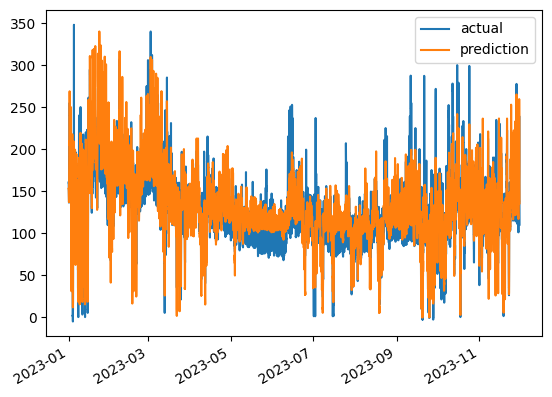

In [136]:
tuned_params = {'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.01}

cat = CatBoostRegressor(verbose=100, iterations=1000, task_type = "GPU", **tuned_params)
cat.fit(X_train, y_train)
prediction_2 = cat.predict(X_test)

fig, ax = plt.subplots()
ax.plot(df["PREDICTION_TIME"].loc[test_index], y_test, label = "actual")
ax.plot(df["PREDICTION_TIME"].loc[test_index], prediction_2, label = "prediction")
fig.autofmt_xdate()
ax.legend()

In [137]:
print("Evaluation on 2023")
evaluate(y_test, prediction_2)
print("Evaluation on nearest day")
evaluate(y_test[:48], prediction_2[:48])

Evaluation on 2023
Report: 

              MAE: 16.979735893803895

              MAPE: 128209410052908.3 

              SMAPE: 0.15751151159063503

              RMSE: 22.420167720804212 

              MAE_peak: 24.62805556549765

              MAE_nonpeak: 14.629477491998152
Evaluation on nearest day
Report: 

              MAE: 12.041342236819133

              MAPE: 0.06340139251361049 

              SMAPE: 0.06005201648189652

              RMSE: 17.06721343450514 

              MAE_peak: 15.064448518906463

              MAE_nonpeak: 2.97202339055715


{'MAE': 12.041342236819133,
 'MAPE': 0.06340139251361049,
 'SMAPE': 0.06005201648189652,
 'RMSE': 17.06721343450514,
 'MAE_peak': 15.064448518906463,
 'MAE_nonpeak': 2.97202339055715}

# 3. Feature selection

0:	learn: 99.5901924	total: 13.3ms	remaining: 13.3s
100:	learn: 56.3965356	total: 1.35s	remaining: 12s
200:	learn: 40.9434780	total: 2.6s	remaining: 10.4s
300:	learn: 35.6533001	total: 3.86s	remaining: 8.97s
400:	learn: 33.3621261	total: 5.28s	remaining: 7.89s
500:	learn: 32.0319677	total: 6.58s	remaining: 6.55s
600:	learn: 31.0271154	total: 7.88s	remaining: 5.23s
700:	learn: 30.1919893	total: 9.21s	remaining: 3.93s
800:	learn: 29.4892592	total: 10.5s	remaining: 2.62s
900:	learn: 28.8573861	total: 11.8s	remaining: 1.29s
999:	learn: 28.2700520	total: 13.1s	remaining: 0us
0:	learn: 99.5881090	total: 14.8ms	remaining: 14.8s
100:	learn: 56.3523213	total: 1.25s	remaining: 11.2s
200:	learn: 40.8572155	total: 2.58s	remaining: 10.3s
300:	learn: 35.6142407	total: 3.94s	remaining: 9.14s
400:	learn: 33.3239130	total: 5.31s	remaining: 7.93s
500:	learn: 31.9997436	total: 6.52s	remaining: 6.5s
600:	learn: 30.9985048	total: 7.77s	remaining: 5.16s
700:	learn: 30.1452389	total: 8.95s	remaining: 3.82s
8

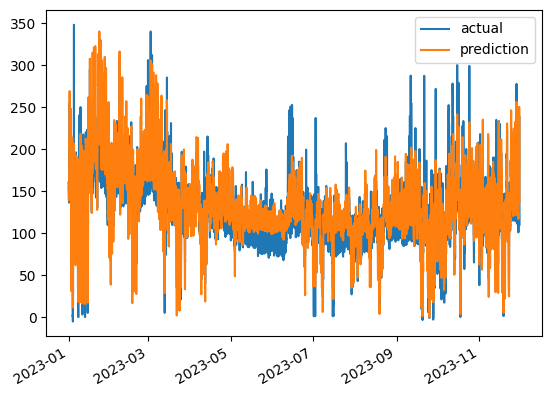

In [138]:
from sklearn.feature_selection import RFE


selector = RFE(cat, n_features_to_select=180, step=50)
selector = selector.fit(X_train, y_train)

selected_feature = selector.get_feature_names_out()

prediction_3 = selector.predict(X_test)

fig, ax = plt.subplots()
ax.plot(df["PREDICTION_TIME"].loc[test_index], y_test, label = "actual")
ax.plot(df["PREDICTION_TIME"][test_index], prediction_3, label = "prediction")
fig.autofmt_xdate()
ax.legend()

In [139]:
print("Evaluation on 2023")
evaluate(y_test, prediction_3)
print("Evaluation on nearest day")
evaluate(y_test[:48], prediction_3[:48])

Evaluation on 2023
Report: 

              MAE: 16.896328391818713

              MAPE: 131558765852450.72 

              SMAPE: 0.1564855614623509

              RMSE: 22.263526565543028 

              MAE_peak: 24.23558824661653

              MAE_nonpeak: 14.64104123369784
Evaluation on nearest day
Report: 

              MAE: 10.603781815509924

              MAPE: 0.055285461688569716 

              SMAPE: 0.05246492912878181

              RMSE: 15.41716054968271 

              MAE_peak: 13.478299939414619

              MAE_nonpeak: 1.9802274437958403


{'MAE': 10.603781815509924,
 'MAPE': 0.055285461688569716,
 'SMAPE': 0.05246492912878181,
 'RMSE': 15.41716054968271,
 'MAE_peak': 13.478299939414619,
 'MAE_nonpeak': 1.9802274437958403}

**Insight:**
The model only improve slightly from previous -> keep all features

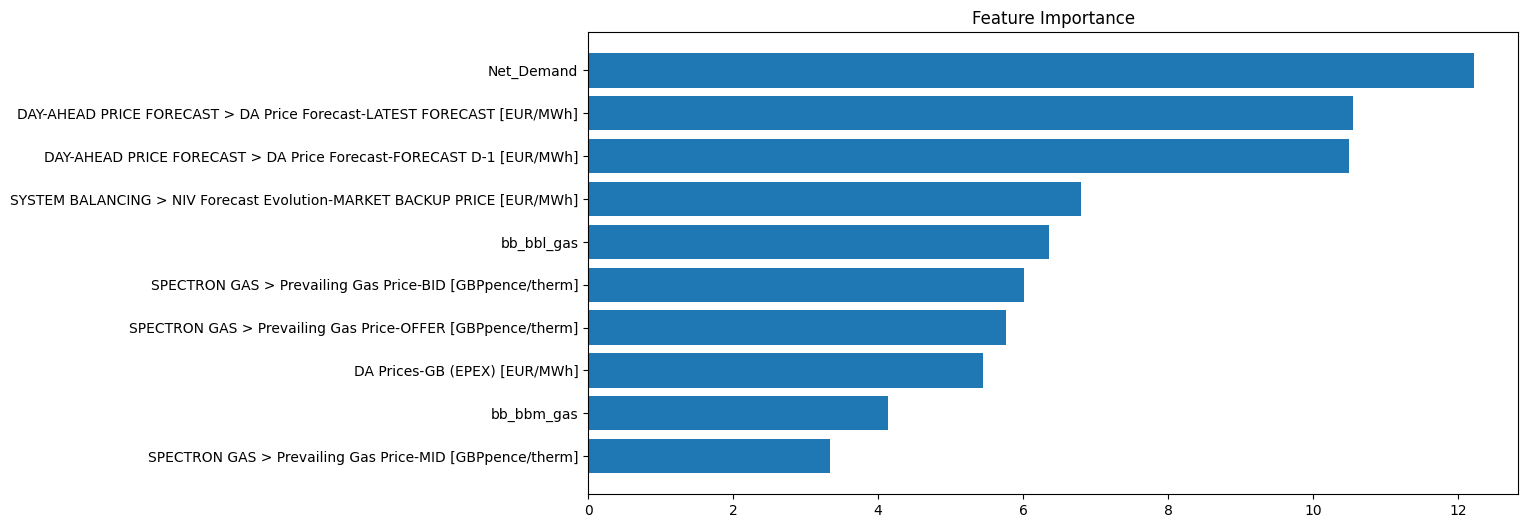

In [140]:
plot_feature_importance(cat, 10)

# 3. Tune training time range

In [141]:
length_of_history = 480 # 10 days

length_hist = []
eval_hist = []
for i in range(1, 100):
    length = length_of_history * i
    print(f"Current length: {length}")
    X_train_short = X.loc[X_test.index.min() - length:X_test.index.min()]
    y_train_short = y.loc[X_test.index.min() - length:X_test.index.min()]
    cat = CatBoostRegressor(verbose=0, iterations=1000, task_type = "GPU", **tuned_params)
    cat.fit(X_train_short, y_train_short)
    prediction = cat.predict(X_test)
    
    length_hist.append(length)
    eval_hist.append(evaluate(y_test, prediction, display = False))
    if length > len(X_train):
        break
    print(f"finished {i}")

Current length: 480
finished 1
Current length: 960
finished 2
Current length: 1440
finished 3
Current length: 1920
finished 4
Current length: 2400
finished 5
Current length: 2880
finished 6
Current length: 3360
finished 7
Current length: 3840
finished 8
Current length: 4320
finished 9
Current length: 4800
finished 10
Current length: 5280
finished 11
Current length: 5760
finished 12
Current length: 6240
finished 13
Current length: 6720
finished 14
Current length: 7200
finished 15
Current length: 7680
finished 16
Current length: 8160
finished 17
Current length: 8640
finished 18
Current length: 9120
finished 19
Current length: 9600
finished 20
Current length: 10080
finished 21
Current length: 10560
finished 22
Current length: 11040
finished 23
Current length: 11520
finished 24
Current length: 12000
finished 25
Current length: 12480
finished 26
Current length: 12960
finished 27
Current length: 13440
finished 28
Current length: 13920
finished 29
Current length: 14400
finished 30
Current len

In [143]:
eval_df = pd.DataFrame(eval_hist)
eval_df["length"] = length_hist


Text(0.5, 0, 'Periods')

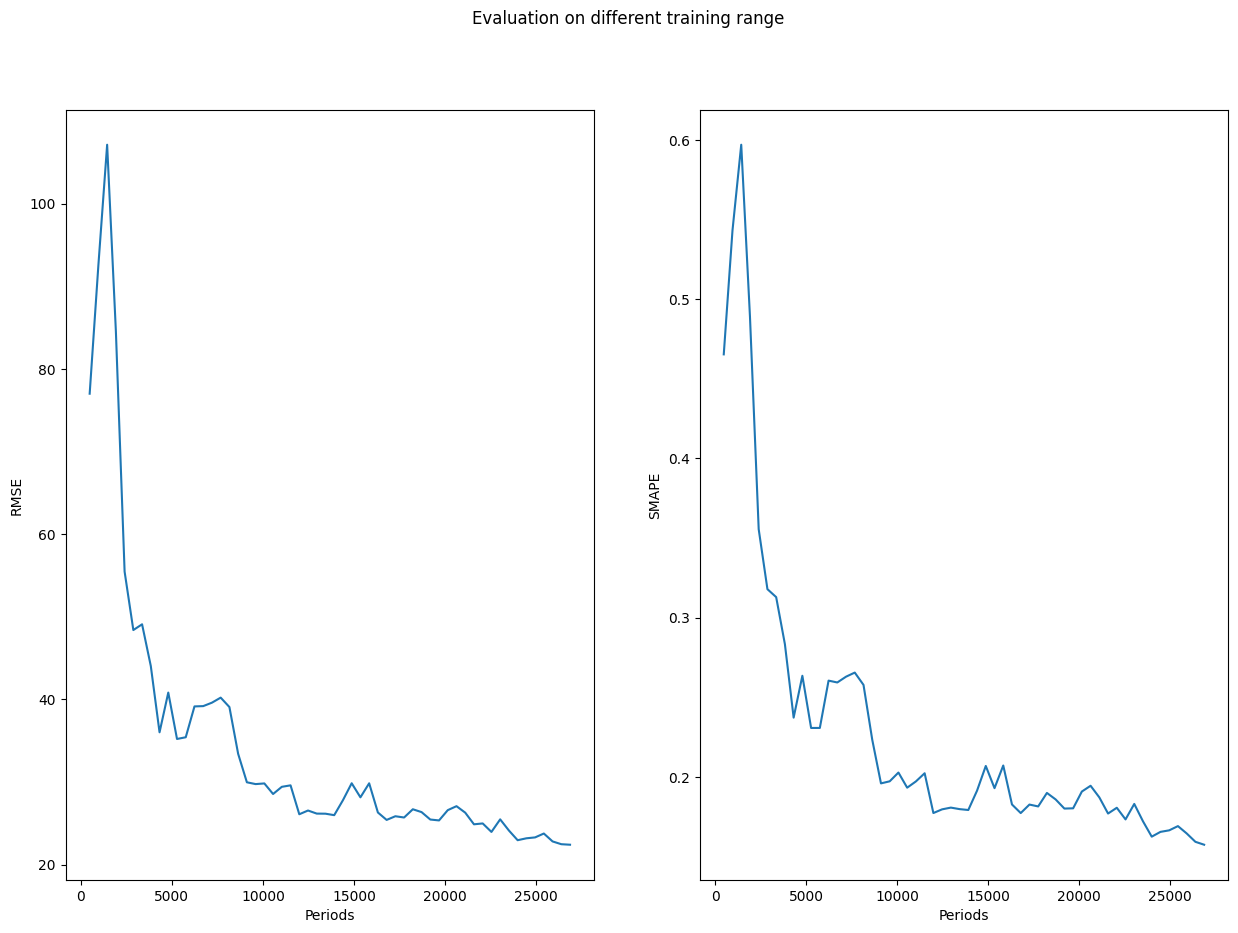

In [144]:
fig, (ax, ax1) = plt.subplots(ncols = 2,figsize = (15, 10))
fig.suptitle("Evaluation on different training range")
ax.plot(eval_df["length"], eval_df["RMSE"])
ax.set_ylabel("RMSE")
ax.set_xlabel("Periods")

ax1.plot(eval_df["length"], eval_df["SMAPE"])
ax1.set_ylabel("SMAPE")
ax1.set_xlabel("Periods")

In [145]:
eval_df[eval_df["SMAPE"] == eval_df["SMAPE"].min()]

,MAE,MAPE,SMAPE,RMSE,MAE_peak,MAE_nonpeak,length
55,16.979736,1.282094e+14,0.157512,22.420168,24.628056,14.629477,26880


In [146]:
eval_df[eval_df["RMSE"] == eval_df["RMSE"].min()]

,MAE,MAPE,SMAPE,RMSE,MAE_peak,MAE_nonpeak,length
55,16.979736,1.282094e+14,0.157512,22.420168,24.628056,14.629477,26880


In [147]:
best = eval_df[eval_df["RMSE"] == eval_df["RMSE"].min()]
best.to_excel("best_test.xlsx")

Using the whole training data still produce best result

# 4. Historical simulation 

Split 0:
Evaluate 2 weeks:
Report: 

              MAE: 17.019051824097318

              MAPE: 0.28409764705154206 

              SMAPE: 0.1731309791092091

              RMSE: 26.217117561424182 

              MAE_peak: 39.38508594022898

              MAE_nonpeak: 11.551799040154023
Evaluate nearest day:
Report: 

              MAE: 16.36654260957084

              MAPE: 0.14770184220450056 

              SMAPE: 0.1359073782410164

              RMSE: 19.641330937194834 

              MAE_peak: 14.001646042526076

              MAE_nonpeak: 17.154841465252428


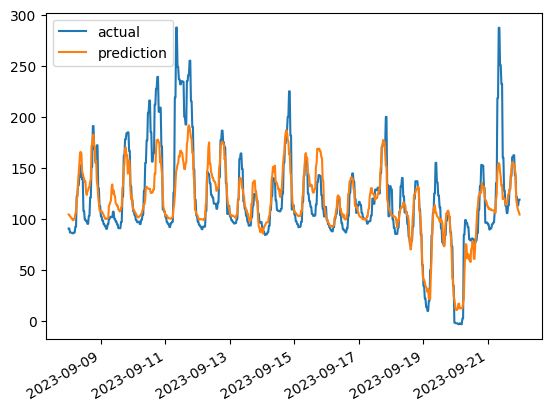

Split 1:
Evaluate 2 weeks:
Report: 

              MAE: 15.141328274122966

              MAPE: 1981655630653116.5 

              SMAPE: 0.23180724297078603

              RMSE: 21.17068307673269 

              MAE_peak: 39.316713303271804

              MAE_nonpeak: 13.364862281565703
Evaluate nearest day:
Report: 

              MAE: 16.83788104519199

              MAPE: 0.1381343138336851 

              SMAPE: 0.13833848932480686

              RMSE: 22.75570682822898 

              MAE_peak: 41.72272090634408

              MAE_nonpeak: 11.86091307296157


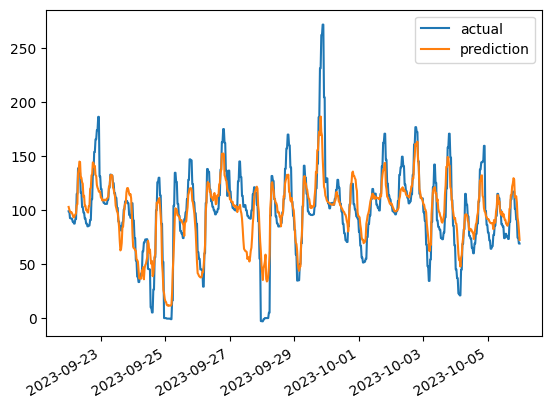

Split 2:
Evaluate 2 weeks:
Report: 

              MAE: 16.521501682192003

              MAPE: 412596581518525.4 

              SMAPE: 0.15456280081557017

              RMSE: 22.645901446457284 

              MAE_peak: 25.29198065262413

              MAE_nonpeak: 13.312789863741227
Evaluate nearest day:
Report: 

              MAE: 12.256860245091048

              MAPE: 0.26366255236183406 

              SMAPE: 0.1962155295494216

              RMSE: 14.773622680452476 

              MAE_peak: 0

              MAE_nonpeak: 12.256860245091048


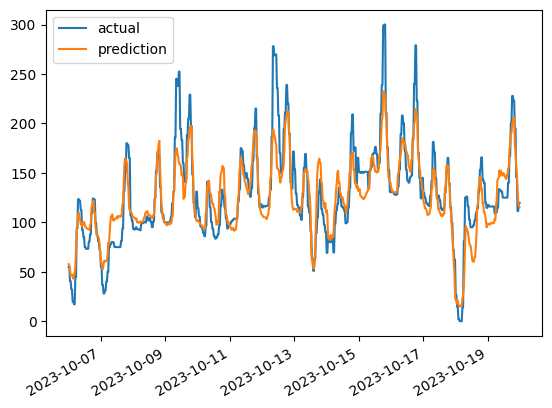

Split 3:
Evaluate 2 weeks:
Report: 

              MAE: 13.37923703193996

              MAPE: 0.11062391687186 

              SMAPE: 0.10321446241793317

              RMSE: 18.408118594116996 

              MAE_peak: 17.216911244523857

              MAE_nonpeak: 12.238306860631234
Evaluate nearest day:
Report: 

              MAE: 19.699450991107504

              MAPE: 0.15562921242530042 

              SMAPE: 0.14814306745122774

              RMSE: 25.71897919612215 

              MAE_peak: 41.58811880989343

              MAE_nonpeak: 15.321717427350318


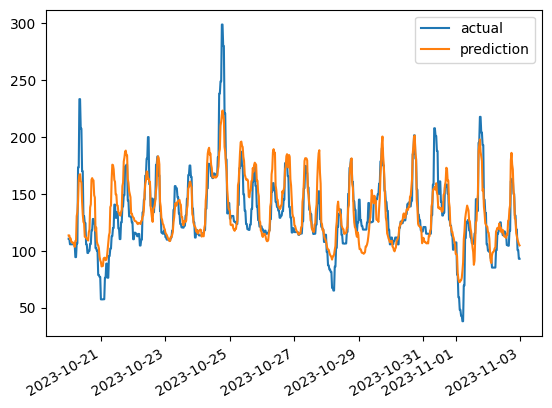

Split 4:
Evaluate 2 weeks:
Report: 

              MAE: 13.152111573186227

              MAPE: 0.11664366620916895 

              SMAPE: 0.1151983877913842

              RMSE: 17.74995430898746 

              MAE_peak: 21.42222480351136

              MAE_nonpeak: 11.905930127520795
Evaluate nearest day:
Report: 

              MAE: 24.471658883855525

              MAPE: 0.22665290604827767 

              SMAPE: 0.2011911465910861

              RMSE: 29.689864623410106 

              MAE_peak: 35.95726341300569

              MAE_nonpeak: 21.44913137618443


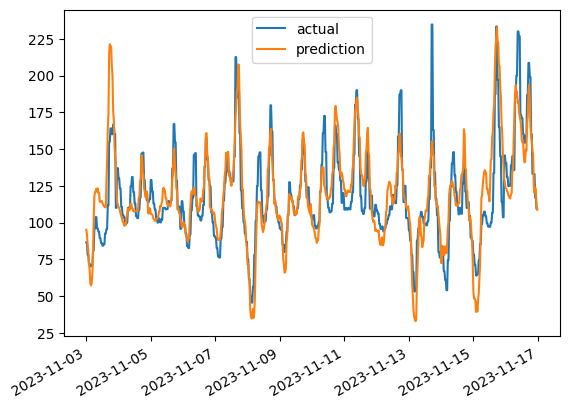

Split 5:
Evaluate 2 weeks:
Report: 

              MAE: 13.752160266833542

              MAPE: 0.24941905997637145 

              SMAPE: 0.13183375678257694

              RMSE: 18.056975082416365 

              MAE_peak: 17.847532819373587

              MAE_nonpeak: 12.408619073707754
Evaluate nearest day:
Report: 

              MAE: 16.610111625133587

              MAPE: 0.13317985866486057 

              SMAPE: 0.12241508136302706

              RMSE: 22.76070502365623 

              MAE_peak: 11.26539156298815

              MAE_nonpeak: 17.679055637562676


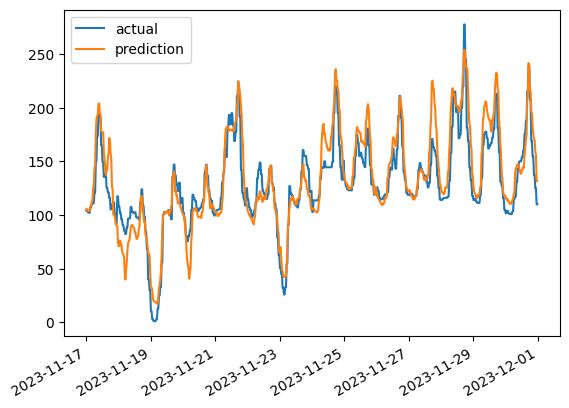

In [148]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(test_size=48*14, n_splits = 6, gap = 0)

"""X = df.drop(["Time Start (WET)", "TARGET", "PREDICTION_TIME", "index"], axis = 1)
y = df["TARGET"]
X = X[selector.get_feature_names_out()]"""
eval_2_weeks_rows = []
eval_nearest_day_rows = []
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    cat = CatBoostRegressor(verbose=0, iterations=1000, task_type = "GPU", **tuned_params)
    cat.fit(X_train, y_train)
    prediction = cat.predict(X_test)
    print(f"Split {i}:")
    print("Evaluate 2 weeks:")
    eval_2_weeks_rows.append(evaluate(y_test, prediction + 0.01))
    print("Evaluate nearest day:")
    eval_nearest_day_rows.append(evaluate(y_test[:48], prediction[:48]))
    fig, ax = plt.subplots()
    ax.plot(df["PREDICTION_TIME"].loc[test_index], y_test, label = "actual")
    ax.plot(df["PREDICTION_TIME"].loc[test_index], prediction, label = "prediction")
    fig.autofmt_xdate()
    ax.legend()
    plt.show()

In [149]:
pd.DataFrame(eval_nearest_day_rows)["SMAPE"].mean()

0.1570351154200976

Split 0:
Evaluate 1 month:
Report: 

              MAE: 27.733815544912638

              MAPE: 767165285912049.8 

              SMAPE: 0.224942040519771

              RMSE: 34.62252460515694 

              MAE_peak: 30.421357739170226

              MAE_nonpeak: 20.854221889755646
Evaluate nearest day:
Report: 

              MAE: 12.046342236819129

              MAPE: 0.0634243738148133 

              SMAPE: 0.06007185648666212

              RMSE: 17.07286051545115 

              MAE_peak: 15.072226296684233

              MAE_nonpeak: 2.9686900572238195


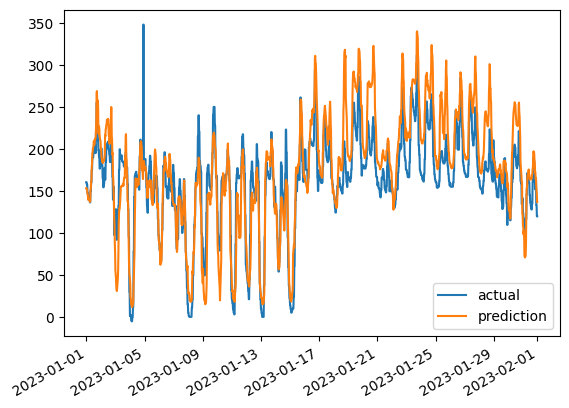

Split 1:
Evaluate 1 month:
Report: 

              MAE: 14.376523771555222

              MAPE: 0.0991600193646103 

              SMAPE: 0.10440569439392244

              RMSE: 18.072964489208534 

              MAE_peak: 13.525204091849574

              MAE_nonpeak: 15.613112211419633
Evaluate nearest day:
Report: 

              MAE: 14.385097600629628

              MAPE: 0.13582405635547426 

              SMAPE: 0.1644842835161391

              RMSE: 19.74062147123924 

              MAE_peak: 6.857437807577159

              MAE_nonpeak: 21.912757393682096


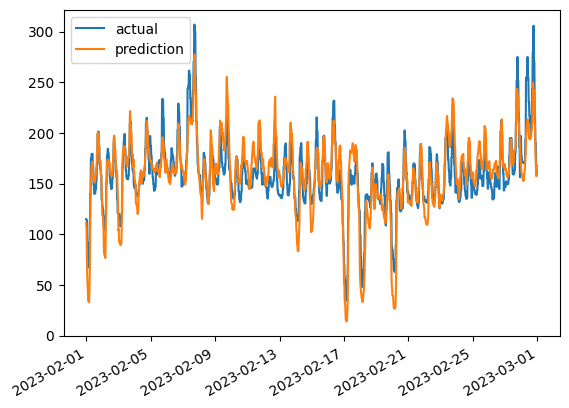

Split 2:
Evaluate 1 month:
Report: 

              MAE: 14.426308661850033

              MAPE: 0.1263857339917329 

              SMAPE: 0.11820724083351596

              RMSE: 18.616986262872867 

              MAE_peak: 17.29377546968169

              MAE_nonpeak: 12.741365558957494
Evaluate nearest day:
Report: 

              MAE: 12.103296488130729

              MAPE: 0.05791400845783513 

              SMAPE: 0.05908804007827789

              RMSE: 17.53195726201789 

              MAE_peak: 12.643732478946516

              MAE_nonpeak: 10.049639723030726


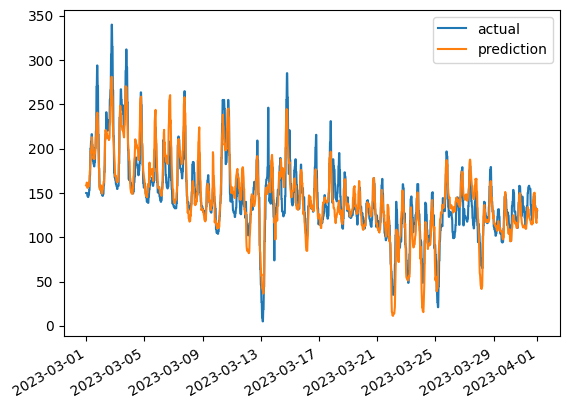

Split 3:
Evaluate 1 month:
Report: 

              MAE: 11.095101695610365

              MAPE: 0.09204021058135867 

              SMAPE: 0.09331468118108506

              RMSE: 14.962846622681404 

              MAE_peak: 13.844567935392757

              MAE_nonpeak: 10.577875373275061
Evaluate nearest day:
Report: 

              MAE: 6.707736973741177

              MAPE: 0.05299931900039661 

              SMAPE: 0.05331109497078019

              RMSE: 8.148462972427346 

              MAE_peak: 8.36073839402205

              MAE_nonpeak: 6.5574641173520085


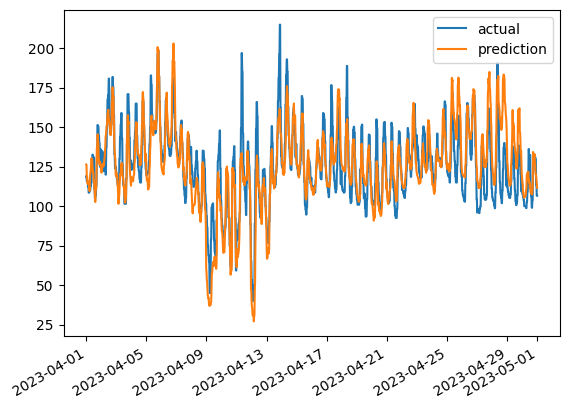

Split 4:
Evaluate 1 month:
Report: 

              MAE: 11.0781236630784

              MAPE: 0.11309592251723412 

              SMAPE: 0.10575425724309927

              RMSE: 13.670253160092196 

              MAE_peak: 26.9883355292951

              MAE_nonpeak: 10.728448677007702
Evaluate nearest day:
Report: 

              MAE: 12.62631924009974

              MAPE: 0.11574233196211121 

              SMAPE: 0.10925791028860574

              RMSE: 14.6211233922099 

              MAE_peak: 13.525620193090845

              MAE_nonpeak: 12.446459049501518


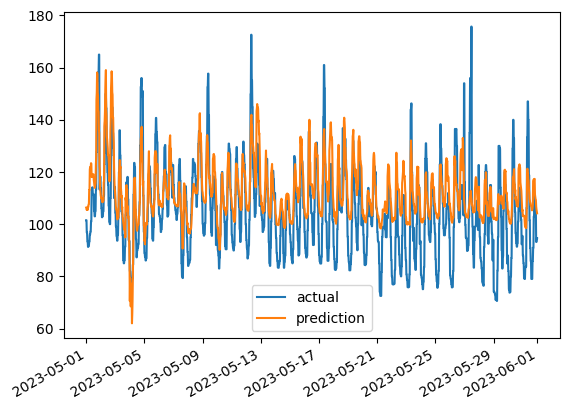

Split 5:
Evaluate 1 month:
Report: 

              MAE: 13.879349088634758

              MAPE: 0.11191245119516323 

              SMAPE: 0.11570579993770927

              RMSE: 21.580704420783714 

              MAE_peak: 38.02438100251598

              MAE_nonpeak: 10.075147918923568
Evaluate nearest day:
Report: 

              MAE: 8.091871804261531

              MAPE: 0.0804907245131349 

              SMAPE: 0.07867178683393088

              RMSE: 10.012570676847202 

              MAE_peak: 0

              MAE_nonpeak: 8.091871804261531


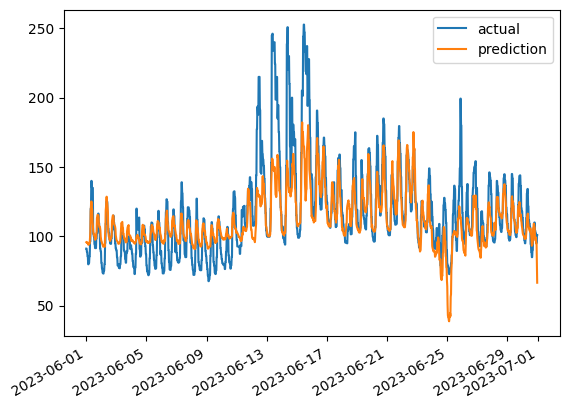

Split 6:
Evaluate 1 month:
Report: 

              MAE: 13.375206133983303

              MAPE: 0.5461581454564846 

              SMAPE: 0.17032667760214804

              RMSE: 18.015734839916178 

              MAE_peak: 43.29214101079733

              MAE_nonpeak: 12.548771468877945
Evaluate nearest day:
Report: 

              MAE: 22.96277295350197

              MAPE: 3.123480309157347 

              SMAPE: 0.4941056839003671

              RMSE: 27.999422897017087 

              MAE_peak: 0

              MAE_nonpeak: 22.96277295350197


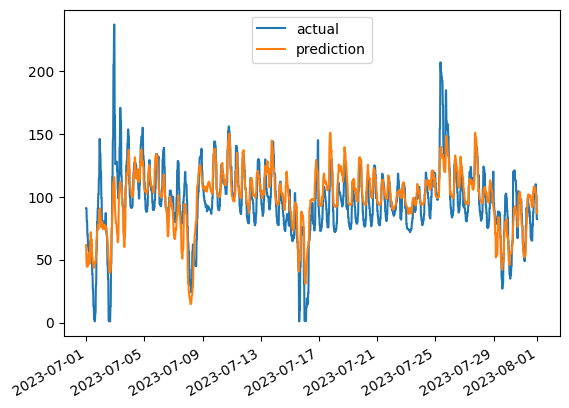

Split 7:
Evaluate 1 month:
Report: 

              MAE: 10.899666890976167

              MAPE: 0.11364405305543329 

              SMAPE: 0.10998333103321886

              RMSE: 13.91735377002852 

              MAE_peak: 19.857948842152002

              MAE_nonpeak: 10.44416102905197
Evaluate nearest day:
Report: 

              MAE: 9.97226411009786

              MAPE: 0.10052535353474805 

              SMAPE: 0.10138410167832329

              RMSE: 11.473579563004298 

              MAE_peak: 0

              MAE_nonpeak: 9.97226411009786


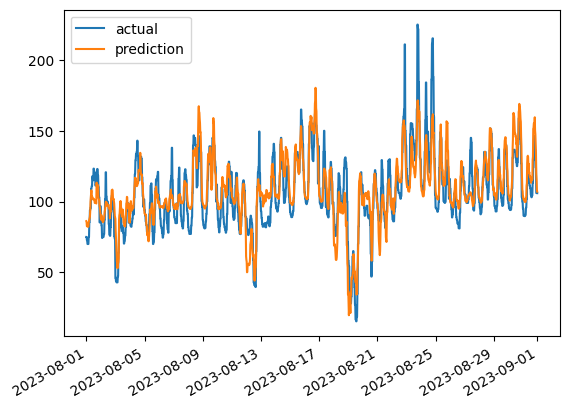

Split 8:
Evaluate 1 month:
Report: 

              MAE: 15.677269526805471

              MAPE: 907296525708387.4 

              SMAPE: 0.18890949936410975

              RMSE: 23.09236609662662 

              MAE_peak: 38.350494587835556

              MAE_nonpeak: 12.438237375229747
Evaluate nearest day:
Report: 

              MAE: 11.015595508520292

              MAPE: 0.08716547123959274 

              SMAPE: 0.08201707008666248

              RMSE: 13.709382767786533 

              MAE_peak: 0

              MAE_nonpeak: 11.015595508520292


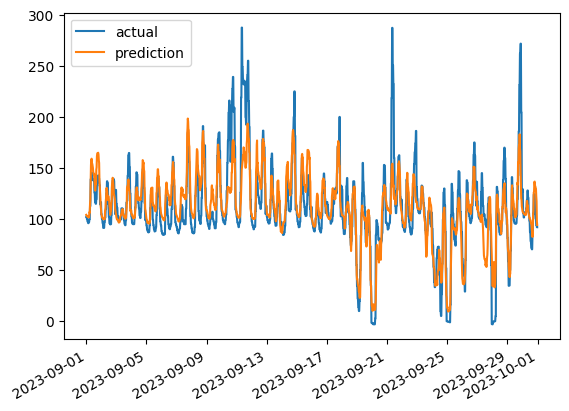

Split 9:
Evaluate 1 month:
Report: 

              MAE: 14.8071592058837

              MAPE: 192092899302188.3 

              SMAPE: 0.13258350008100597

              RMSE: 20.314781271055654 

              MAE_peak: 21.852764492469795

              MAE_nonpeak: 12.736363912956655
Evaluate nearest day:
Report: 

              MAE: 12.285471041389075

              MAPE: 0.1449759224140903 

              SMAPE: 0.13305848929076025

              RMSE: 14.588738955454781 

              MAE_peak: 23.98233089258818

              MAE_nonpeak: 11.22212014582552


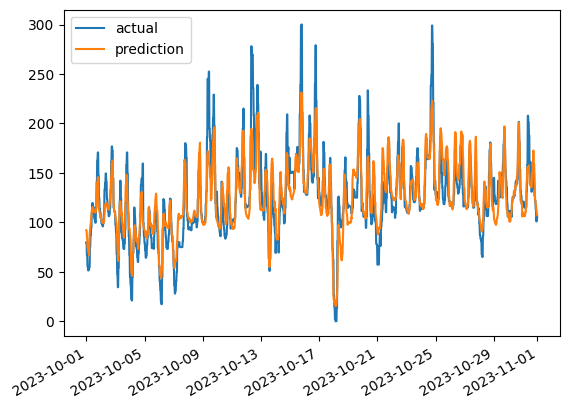

Split 10:
Evaluate 1 month:
Report: 

              MAE: 13.794608129084958

              MAPE: 0.18334865027446134 

              SMAPE: 0.1256632252671554

              RMSE: 18.328456952669576 

              MAE_peak: 20.398239206468556

              MAE_nonpeak: 12.298385074073002
Evaluate nearest day:
Report: 

              MAE: 17.84781240963384

              MAPE: 0.2204724353315739 

              SMAPE: 0.18262551958501952

              RMSE: 21.76808119149846 

              MAE_peak: 23.95429738113934

              MAE_nonpeak: 16.62651541533274


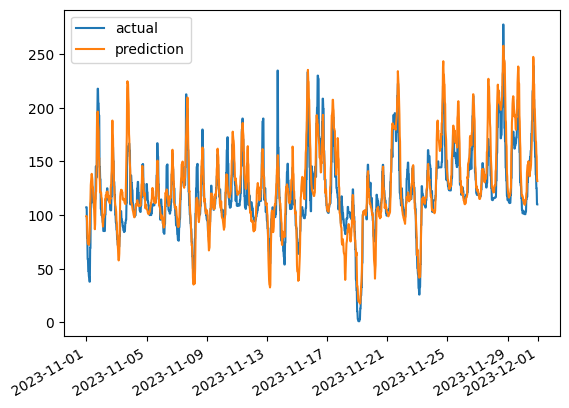

In [150]:
test = df.loc[df[df["PREDICTION_TIME"].dt.year == 2023].index]
end_of_month_indices = test.groupby(pd.Grouper(key='PREDICTION_TIME', freq='M'))['PREDICTION_TIME'].idxmax()
begin_of_month_indices = test.groupby(pd.Grouper(key='PREDICTION_TIME', freq='M'))['PREDICTION_TIME'].idxmin()

eval_1_month_rows = []
eval_nearest_day_rows = []
for i in range(len(end_of_month_indices)):
    begin = begin_of_month_indices.iloc[i]
    end = end_of_month_indices.iloc[i]
    X_train, X_test = X.loc[:begin], X.loc[begin:end]
    y_train, y_test = y.loc[:begin], y.loc[begin:end]
    cat = CatBoostRegressor(verbose=0, iterations=1000, task_type = "GPU", **tuned_params)
    cat.fit(X_train, y_train)
    prediction = cat.predict(X_test)
    print(f"Split {i}:")
    print("Evaluate 1 month:")
    eval_1_month_rows.append(evaluate(y_test, prediction))
    print("Evaluate nearest day:")
    eval_nearest_day_rows.append(evaluate(y_test[:48], prediction[:48]))
    fig, ax = plt.subplots()
    ax.plot(df["PREDICTION_TIME"].loc[begin:end], y_test, label = "actual")
    ax.plot(df["PREDICTION_TIME"].loc[begin:end], prediction, label = "prediction")
    fig.autofmt_xdate()
    ax.legend()
    plt.show()

**Insight:**
The model perform poorly when price's spike is above 200

In [151]:
monthly_report = pd.DataFrame(eval_1_month_rows, index = end_of_month_indices.index)
monthly_report.to_excel("monthly_report.xlsx")

In [152]:
monthly_report["SMAPE"].mean()

0.13543599522334013

# 5. Predict on unseen data:

In [177]:
unseen = pd.read_csv("/kaggle/input/seta-energy/SETA_energy/data/processed/clean_unseen.csv")
unseen = feature_engineering(unseen)

X_unseen = unseen.drop(["Time Start (WET)", "TARGET", "PREDICTION_TIME", "index"], axis = 1)
y_unseen = unseen["TARGET"]


In [178]:
cat = CatBoostRegressor(verbose=100, iterations=1000, task_type = "GPU", **tuned_params)
cat.fit(X, y)


0:	learn: 93.0620012	total: 21.4ms	remaining: 21.4s
100:	learn: 50.9996347	total: 1.5s	remaining: 13.3s
200:	learn: 36.3744037	total: 2.96s	remaining: 11.8s
300:	learn: 31.5174366	total: 4.39s	remaining: 10.2s
400:	learn: 29.5313425	total: 5.73s	remaining: 8.56s
500:	learn: 28.3799888	total: 7.08s	remaining: 7.05s
600:	learn: 27.5590726	total: 8.33s	remaining: 5.53s
700:	learn: 26.8880338	total: 9.62s	remaining: 4.11s
800:	learn: 26.3106739	total: 11s	remaining: 2.73s
900:	learn: 25.8088302	total: 12.4s	remaining: 1.37s
999:	learn: 25.3612307	total: 13.8s	remaining: 0us


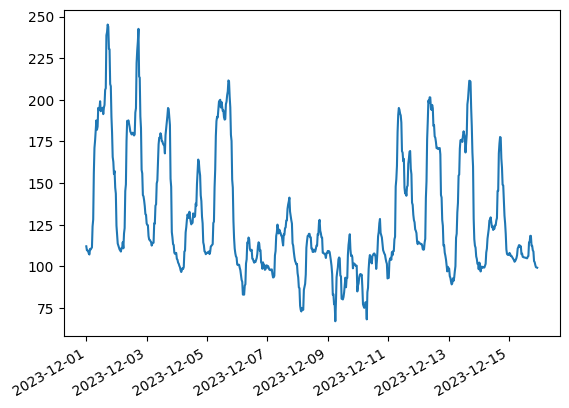

In [179]:
cat.predict(X_unseen)

fig, ax = plt.subplots()
ax.plot(unseen["PREDICTION_TIME"], cat.predict(X_unseen), label = "actual")
fig.autofmt_xdate()

In [173]:
output = pd.DataFrame()
output["DA Prices-IRELAND (IE) [EUR/MWh]"] = cat.predict(X_unseen)
output.index = unseen["PREDICTION_TIME"]
output.index = output.index.rename("Time Start(WET)")
output.to_excel("predict_unseen.xlsx")